# MRV Emissions Exploration

_Author: Robert Dibble_

The European Union requires ships larger than 5000 tons that dock in the EU to declare their emissions to the MRV system, the data of which is made available publicly. This notebook aims to explore the dataset and investigate any modelling opportunities.

A description of the different ship types:

| Ship type | Description |
| ----------- | ----------- |
| Bulk carrier | A ship which is intended primarily to carry dry cargo in bulk, including such types as ore carriers. |
| Chemical tanker | A chemical tanker is a type of tanker ship designed to transport chemicals in bulk. As well as industrial chemicals and clean petroleum products, such ships also often carry other types of sensitive cargo which require a high standard of tank cleaning, such as palm oil, vegetable oils, tallow, caustic soda, and methanol. |
| Combination carrier | A ship designed to load 100% deadweight with both liquid and dry cargo in bulk. |
| Container ship | A ship designed exclusively for the carriage of containers in holds and on deck. |
| Container/ro-ro cargo ship | A ship that can take a combination of containers and ro-ro cargo |
| Gas carrier | A cargo ship constructed or adapted and used for the carriage in bulk of any liquefied gas. |
| General cargo ship | A ship with a multi-deck or single deck hull designed primarily for the carriage of general cargo. |
| LNG carrier | An LNG carrier is a tank ship designed for transporting liquefied natural gas. |
| Oil tanker | An oil tanker, also known as a petroleum tanker, is a ship designed for the bulk transport of oil or its products. |
| Other ship types |  |
| Passenger ship | A passenger ship is a merchant ship whose primary function is to carry passengers on the sea. The category does not include cargo vessels which have accommodations for limited numbers of passengers. |
| Refrigerated cargo carrier | A ship designed exclusively for the carriage of refrigerated cargoes in holds. |
| Ro-pax ship | The acronym ROPAX (roll-on/roll-off passenger) describes a RORO vessel built for freight vehicle transport along with passenger accommodation. |
| Ro-ro ship | Roll-on/roll-off (RORO or ro-ro) ships are cargo ships designed to carry wheeled cargo, such as cars, motorcycles, trucks, semi-trailer trucks, buses, trailers, and railroad cars, that are driven on and off the ship on their own wheels or using a platform vehicle. |
| Vehicle carrier | A multi deck roll-on-roll-off cargo ship designed for the carriage of empty cars and trucks |

## Initialise

### Import libraries

In [1]:
# third party libraries
from matplotlib import cm, pyplot as plt, ticker
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import utils
import warnings
import unittest

# set seed
seed = 42
np.random.seed(seed)

# user created/published libraries
from datavizml.exploratorydataanalysis import ExploratoryDataAnalysis

# run unit tests
_ = unittest.TextTestRunner(verbosity=2).run(
    unittest.TestLoader().loadTestsFromModule(utils)
)

test_outlier_removal (utils.test_transformer) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.014s

OK


### Load raw data

Sourced from [EU-MRV system](https://mrv.emsa.europa.eu/#public/emission-report)

_N.B. Brexit is not reflected until 2021 (incl) onwards_

In [2]:
# initialise empty list to store each year's dataframe in
yearly_data = []

# extract all filenames in 'data' folder
filename_all = os.listdir("data")

# loop through all files in folder
for i, filename in enumerate(filename_all):
    # print progress through folder
    print(f"Loading {i+1} of {len(filename_all)}: {filename}")

    # suppress irrelevant warning "Workbook contains no default style, apply openpyxl's default"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # load dataframe
        df_temp = pd.read_excel(
            os.path.join("data", filename),
            header=2,
            na_values=[
                "Division by zero!"
            ],  # add additional values as observed throughout development process
        )

        # rename column as name changed between 2019 and 2020
        df_temp.rename(
            columns={
                "Annual Total time spent at sea [hours]": "Annual Time spent at sea [hours]"
            },
            inplace=True,
        )

        # add current dataframe to list of other year's dataframes
        yearly_data.append(df_temp)

# combine data from each year into one dataframe
raw_df = pd.concat(yearly_data, ignore_index=True)

Loading 1 of 4: 2018-v268-06102022-EU MRV Publication of information.xlsx
Loading 2 of 4: 2019-v211-07102022-EU MRV Publication of information.xlsx
Loading 3 of 4: 2020-v181-01122022-EU MRV Publication of information.xlsx
Loading 4 of 4: 2021-v104-21122022-EU MRV Publication of information.xlsx


In [3]:
# check that no vessel is duplicated within a year
imo_year_count = raw_df[["IMO Number", "Reporting Period"]].value_counts()
assert (imo_year_count == 1).all()

In [4]:
# downselect columns of interest for brevity and set dtype to minimise memory use
selected_columns_dtype = {
    "IMO Number": int,
    "Ship type": "category",
    "Reporting Period": int,
    "Technical efficiency": object,
    "Total fuel consumption [m tonnes]": float,
    "Fuel consumptions assigned to On laden [m tonnes]": float,
    "Total CO₂ emissions [m tonnes]": float,
    "CO₂ emissions assigned to Passenger transport [m tonnes]": float,
    "CO₂ emissions assigned to Freight transport [m tonnes]": float,
    "CO₂ emissions assigned to On laden [m tonnes]": float,
    "Annual Time spent at sea [hours]": float,
    "Annual average Fuel consumption per distance [kg / n mile]": float,
    "Annual average CO₂ emissions per distance [kg CO₂ / n mile]": float,
}
main_df = raw_df[selected_columns_dtype.keys()].astype(selected_columns_dtype)

### Process _Technical efficiency_ data

_Technical efficiency_ is the amount of CO₂ release per tonne of capacity per nautical mile traversed. This data is reported as a string in the format `'<calculation type> (<numerical value> gCO₂/t·nm)'` and subsequently needs to be preocessed to separate these 2 pieces of information.

The preferred method to calulcate this is to use the Energy Efficiency Design Index (EEDI) equation:
$$\dfrac{\Sigma_{i=1}^{N} \left( P_i \times SFC_i \times CF_i \right)}{Capacity \times Speed}$$
where:
- $N$ is the number of engines
- $P_i$ is the power of the $i^{th}$ engine
- $SFC_i$ is the specific fuel consumption of the $i^{th}$ engine
- $CF_i$ is the carbon emission factor of the fuel of the $i^{th}$ engine.

Alternatively, EIV (Estimated Index Value) is calculated using the following assumptions for main engines (ME) and auxilliary engines (AE):
- The carbon emission factor ($CF$) is constant for all engines, $CF_{ME}$ = $CF_{AE}$ = 3.1144 g CO₂/g fuel.
- The specific fuel consumption ($SFC$) for all ship types is constant for all main engines, $SFC_{ME}$ = 190 g/kWh.
- The specific fuel consumption for all ship types is constant for all auxiliary engines, $SFC_{AE}$ = 215 g/kWh.
- Capacity is defined as 70% of deadweight for containerships and 100% of deadweight for other ship types.

Sources:
1. EEIV: [MAN Energy Solutions](https://www.man-es.com/docs/default-source/document-sync/eedi-eng.pdf?sfvrsn=23fbab95_2)
1. EIV: [Transport and Environment office](https://www.transportenvironment.org/wp-content/uploads/2021/07/2015%2005%20CE_Delft_7E50_Estimated_Index_Values_of_New_Ships_DEF.pdf)


In [5]:
# split column into list of both values
split_combined = main_df["Technical efficiency"].apply(
    lambda x: utils.tech_eff_extract(str(x))
)

# separate lists into individual columns in oringinal dataframe
split_separate = pd.DataFrame(split_combined.to_list()).astype(
    {0: "category", 1: float}
)
main_df[
    ["Technical efficiency type", "Technical efficiency value [gCO₂/t·nm]"]
] = split_separate

# drop unprocessed column
main_df.drop(columns=["Technical efficiency"], inplace=True)

### Calculate distance travelled, average speed and ship deadweight

In [6]:
# calculate distance travelled

# calculate distance from both pairs of columns
dist_fuel_temp = (
    main_df["Total fuel consumption [m tonnes]"]
    * 1000
    / main_df["Annual average Fuel consumption per distance [kg / n mile]"]
)
dist_co2_temp = (
    main_df["Total CO₂ emissions [m tonnes]"]
    * 1000
    / main_df["Annual average CO₂ emissions per distance [kg CO₂ / n mile]"]
)

# average the two methods
dist_temp = (dist_fuel_temp + dist_co2_temp - 1) / 2

# assert the 2 methods agree with each other (to within 1%)
assert not ((abs(dist_fuel_temp - dist_co2_temp) / dist_temp - 1) > 0.01).any()

# save values to dataframe
main_df["Distance travelled [n mile]"] = dist_temp

In [7]:
# calculate average speed
main_df["Average speed [knots]"] = (
    main_df["Distance travelled [n mile]"] / main_df["Annual Time spent at sea [hours]"]
).replace(np.inf, np.nan)

In [8]:
# calculate ship deadweight

# calculate capacity as per EEDI calculation
cap_temp = (
    main_df["Total fuel consumption [m tonnes]"]
    * 1e6
    / main_df["Technical efficiency value [gCO₂/t·nm]"]
    / main_df["Distance travelled [n mile]"]
).replace(np.inf, np.nan)

# calculate deadweight from capacity using EIV assumption about container ships
cap_dwt_ratio = main_df["Ship type"].apply(
    lambda x: 0.7 if "container" in x.lower() else 1.0
)
main_df["Deadweight [m tonnes]"] = cap_temp / cap_dwt_ratio

## Data preprocessing to remove/reduce missing data and outliers

In [9]:
# drop rows where ship has consumed no fuel and emitted no CO₂
main_df = main_df.loc[
    (main_df["Total fuel consumption [m tonnes]"] != 0)
    | (main_df["Total CO₂ emissions [m tonnes]"] != 0)
]

In [10]:
# limit annual time at sea to the duration of a year
main_df["Annual Time spent at sea [hours]"].clip(upper=365 * 24, inplace=True)

In [11]:
# remove outliers based on standard deviation of column values; either considering their raw values of their log2
main_df = utils.OutlierRemoval(
    sd_threshold=4,  # considering the size of the dataset, data points beyond the normally accepted 3SD would be expected
    linear_cols=[],
    log2_cols=[
        "Total fuel consumption [m tonnes]",
        "Fuel consumptions assigned to On laden [m tonnes]",
        "Total CO₂ emissions [m tonnes]",
        "CO₂ emissions assigned to Passenger transport [m tonnes]",
        "CO₂ emissions assigned to Freight transport [m tonnes]",
        "CO₂ emissions assigned to On laden [m tonnes]",
        "Annual Time spent at sea [hours]",
        "Annual average Fuel consumption per distance [kg / n mile]",
        "Annual average CO₂ emissions per distance [kg CO₂ / n mile]",
        "Technical efficiency value [gCO₂/t·nm]",
        "Distance travelled [n mile]",
        "Average speed [knots]",
        "Deadweight [m tonnes]",
    ],
).fit_transform(main_df)

In [12]:
# calculate missing data proportion
missing_prop = main_df.isnull().mean()

In [13]:
# drop columns with too much missing data
drop_cols = missing_prop.loc[missing_prop > 0.5].index
main_df.drop(columns=drop_cols, inplace=True)

## Exploratory data analysis

In [14]:
# drop id from data to display and rename columns to reduce line length
multi_line_column_names = {
    i: i.replace(" [", "\n[", 1) if " [" in i else i for i in main_df.columns
}
disp_df = main_df.drop(columns="IMO Number").rename(columns=multi_line_column_names)

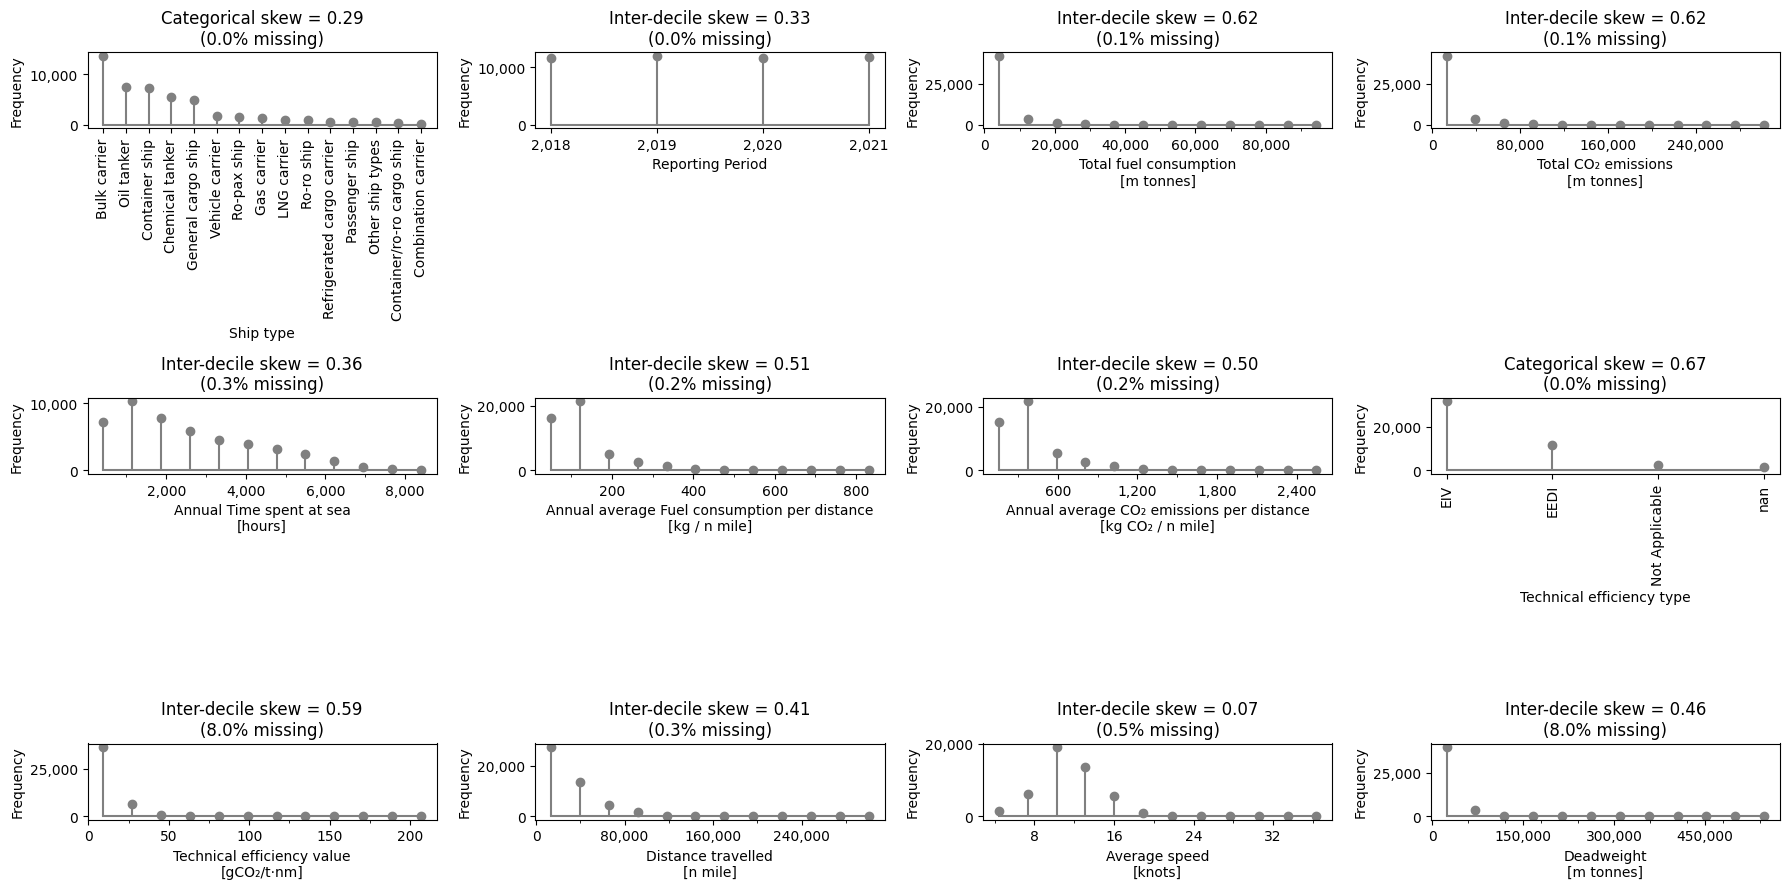

In [15]:
eda = ExploratoryDataAnalysis(data=disp_df, ncols=4, axes_height=3)
fig = eda()
fig.tight_layout()

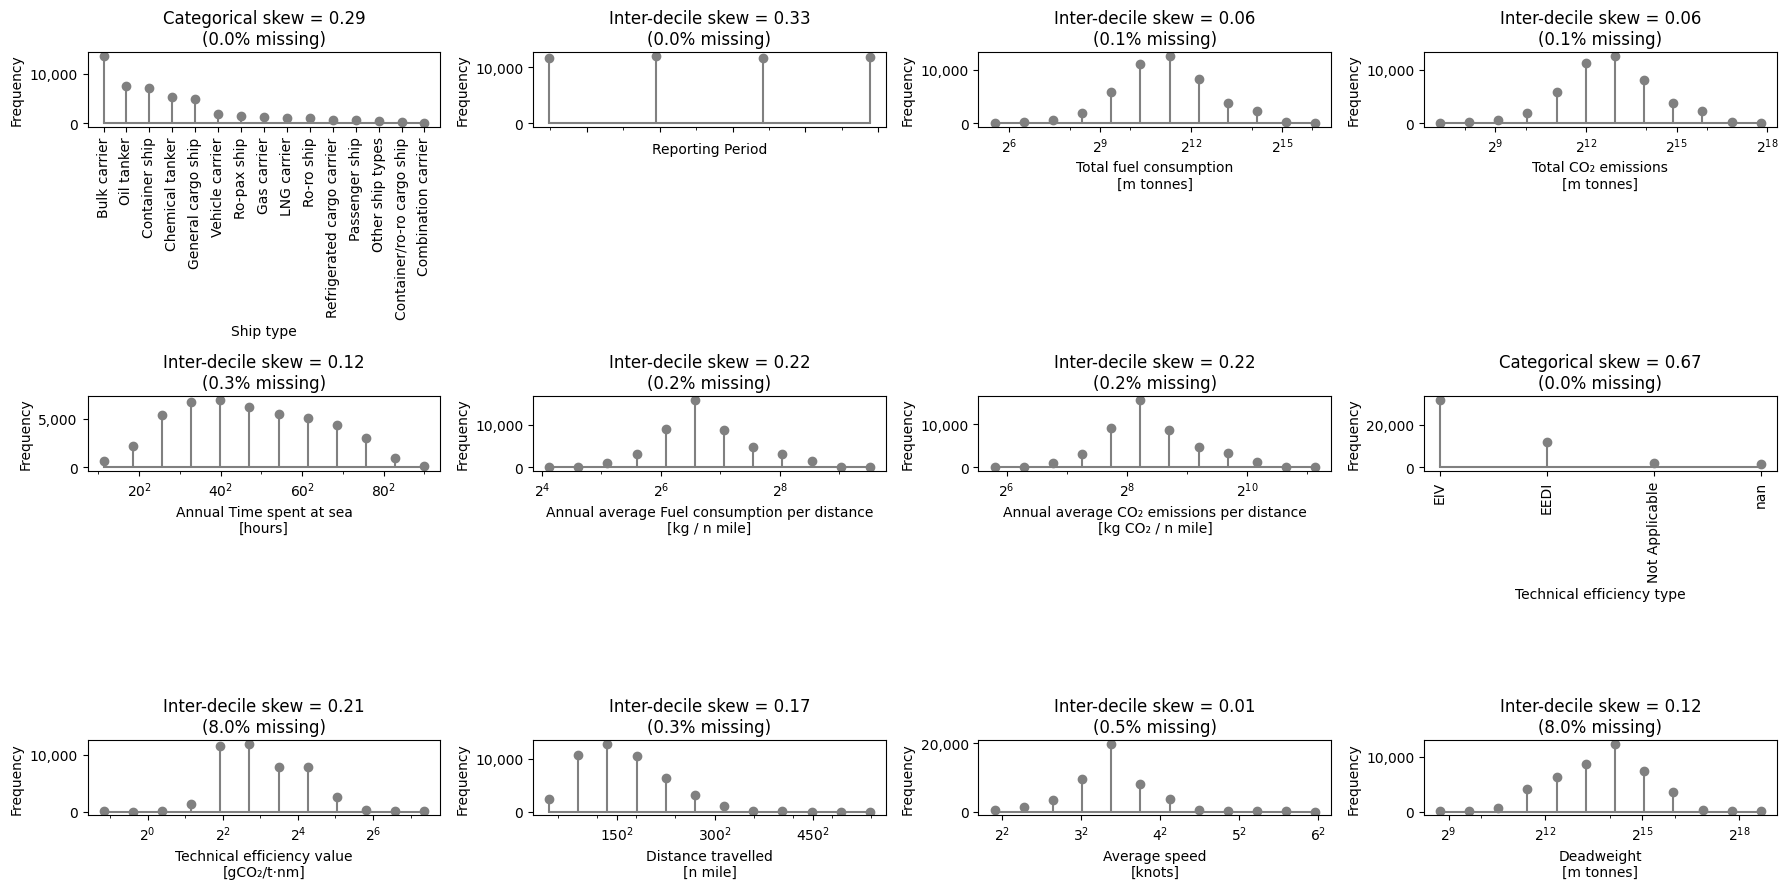

In [16]:
eda = ExploratoryDataAnalysis(data=disp_df, ncols=4, data_deskew=True, axes_height=3)
fig = eda()
fig.tight_layout()

In [17]:
eda.summary()

,feature_name,feature_dtype,feature_score,feature_score_type,feature_transform,feature_nunique,feature_missing_proportion,target_name,target_dtype,target_score,target_score_type
0,Ship type,category,0.288752,Categorical skew,None,15,0.000000,None,None,NaN,N/A
1,Reporting Period,Float64,0.332551,Inter-decile skew,yeojohnson,4,0.000000,None,None,NaN,N/A
2,Total fuel consumption\n[m tonnes],Float64,0.060662,Inter-decile skew,log-2,44096,0.001271,None,None,NaN,N/A
3,Total CO₂ emissions\n[m tonnes],Float64,0.059225,Inter-decile skew,log-2,46545,0.001271,None,None,NaN,N/A
4,Annual Time spent at sea\n[hours],Float64,0.119912,Inter-decile skew,square-root,38974,0.002711,None,None,NaN,N/A
5,Annual average Fuel consumption per distance\n...,Float64,0.221699,Inter-decile skew,log-2,18815,0.001588,None,None,NaN,N/A
6,Annual average CO₂ emissions per distance\n[kg...,Float64,0.215609,Inter-decile skew,log-2,31276,0.001673,None,None,NaN,N/A
7,Technical efficiency type,category,0.671750,Categorical skew,None,4,0.000000,None,None,NaN,N/A
8,Technical efficiency value\n[gCO₂/t·nm],Float64,0.214068,Inter-decile skew,log-2,3032,0.080077,None,None,NaN,N/A
9,Distance travelled\n[n mile],Float64,0.169738,Inter-decile skew,square-root,47051,0.003431,None,None,NaN,N/A


## In depth analysis

### Ship type distribution

In [18]:
# calculate number of ships of each type

# calculate per year
ship_type_counts = (
    main_df[["IMO Number", "Ship type", "Reporting Period"]]
    .groupby(["Ship type", "Reporting Period"])
    .count()
    .pivot_table(index="Ship type", columns="Reporting Period")
)
ship_type_counts.columns = ship_type_counts.columns.droplevel(0)

# calculate total across years
ship_type_counts_total = (
    main_df[["IMO Number", "Ship type"]]
    .groupby(["Ship type"])
    .nunique()
    .rename(columns={"IMO Number": "Total"})
)
ship_type_counts = pd.concat([ship_type_counts, ship_type_counts_total], axis=1)

# add total across types
ship_type_counts.loc["Total"] = ship_type_counts.sum()

# display values
display(ship_type_counts)

,2018,2019,2020,2021,Total
Ship type,,,,,
Bulk carrier,3478,3447,3204,3505,6214
Chemical tanker,1324,1348,1337,1368,1941
Combination carrier,10,11,15,6,18
Container ship,1738,1815,1824,1800,2503
Container/ro-ro cargo ship,80,76,70,64,89
Gas carrier,309,340,342,327,533
General cargo ship,1155,1230,1221,1232,1616
LNG carrier,210,257,266,285,383
Oil tanker,1815,1963,1918,1833,2901


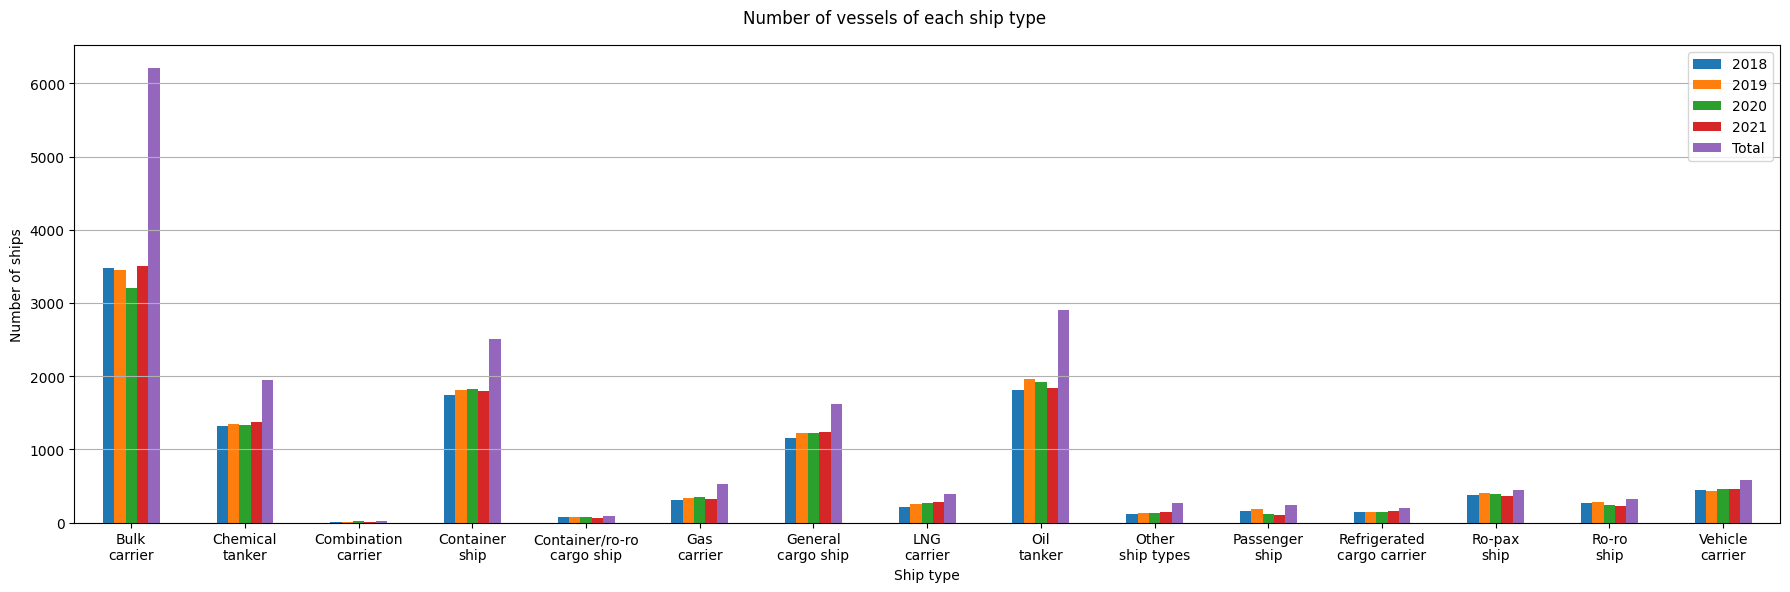

In [19]:
# display count of ships of each type
fig, ax = plt.subplots(figsize=(18, 6))
ship_type_counts.drop("Total").plot.bar(ax=ax)
ax.set_ylabel("Number of ships")
ax.tick_params(axis="x", labelrotation=0)
ax.set_xticklabels(
    [x.get_text().replace(" ", "\n", 1) for x in ax.get_xticklabels()]
)  # make labels multiline
ax.grid(visible=True, axis="y")
fig.suptitle("Number of vessels of each ship type")
fig.tight_layout()

The ratio of the total number of ships to the annual number of ships is indicative of the turnover rate for ships of that type. Visually, it is very clear that the turnover rate for _Bulk carriers_ is notably higher than other ship types. Conversely, ship types involving vehicles (_Container/ro-ro cargo ship_, _Ro-pax ship_, _Ro-ro ship_, _Vehicle carrier_) exhibit a significantly lower turnover rate. If whole lifecycle emissions are to be accounted for then being able to estimate the lifetime of the ship would be beneficial.

_N.B._ This analysis assumes that an _IMO Number_ has a one-to-one relationship to ship. If it is possible for multiple vessels to share an _IMO Number_ or for a single vessel to have multiple _IMO Numbers_, this analysis will be flawed.

### Relationship between deadweight and emissions intensity

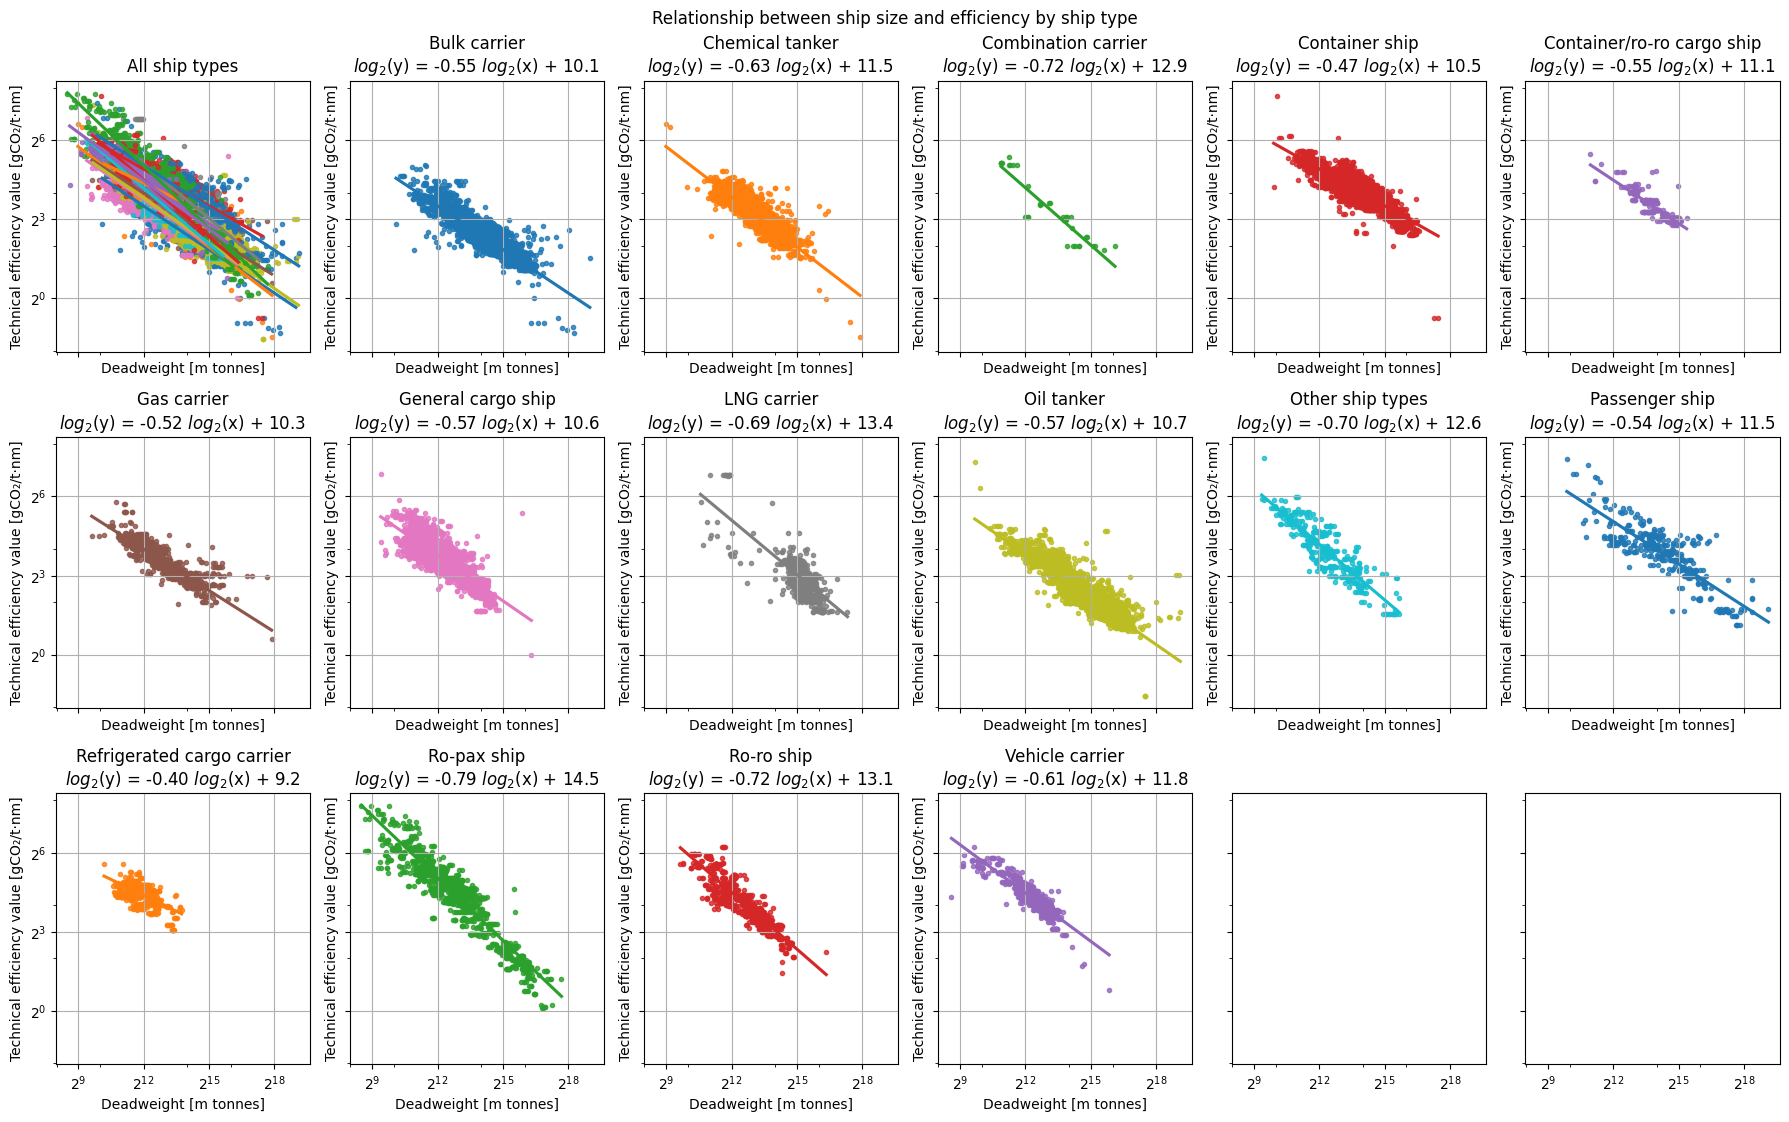

In [20]:
# display relationship between ship type and technical efficiency value

# create copy of data in log2 form
main_df_temp_log = main_df.copy()
main_df_temp_log[
    ["Technical efficiency value [gCO₂/t·nm]", "Deadweight [m tonnes]"]
] = utils.log2_fun(
    main_df_temp_log[
        ["Technical efficiency value [gCO₂/t·nm]", "Deadweight [m tonnes]"]
    ]
)

# initialise plot
ncols = 6
nrows = int(np.ceil((main_df["Ship type"].nunique() + 1) / ncols))
fig, ax_all = plt.subplots(
    nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(18, 3.8 * nrows)
)
ax_all = ax_all.flatten()

# initialise colourmap
cmap_raw = [cm.tab10(i) for i in range(10)]
cmap = cmap_raw * int(
    np.ceil(main_df["Ship type"].nunique() / len(cmap_raw))
)  # loop colourmap if necessary

# loop over all ship types
for ship_type, ax_ind, colour in zip(
    np.sort(main_df_temp_log["Ship type"].unique()), ax_all[1:], cmap
):
    # plot relationship on shared and individual axis
    for ax in [ax_all[0], ax_ind]:
        p = sns.regplot(
            data=main_df_temp_log.loc[main_df_temp_log["Ship type"] == ship_type],
            x="Deadweight [m tonnes]",
            y="Technical efficiency value [gCO₂/t·nm]",
            ci=None,
            ax=ax,
            color=colour,
            marker=".",
        )

    # calculate slope and intercept of regression
    slope, intercept, _, _, _ = stats.linregress(
        x=p.get_lines()[0].get_xdata(), y=p.get_lines()[0].get_ydata()
    )

    # decorate axes
    utils.decorate_log_axis(ax_ind, "x")
    utils.decorate_log_axis(ax_ind, "y")
    ax_ind.grid(visible=True)
    ax_ind.set_title(
        f"{ship_type}\n$log_{{2}}$(y) = {slope:0.2f} $log_{{2}}$(x) + {intercept:0.1f}"
    )

# decorate axes
utils.decorate_log_axis(ax_all[0], "x")
utils.decorate_log_axis(ax_all[0], "y")
ax_all[0].grid(visible=True)
ax_all[0].set_title("All ship types")

# decorate figure
fig.suptitle("Relationship between ship size and efficiency by ship type")
fig.tight_layout()

It can be seen that there is a strong relationship between ship size and efficiency. When considering the $log_{2}$ of deadweight and efficiency value, the relationship between the two appears to be quite linear and is present across all ship types. Of all the ship types, _Refrigerated cargo carrier_ type vessels yield the least improvement in efficiency for an increases in size. This is likely due to the additional power required for the refrigeration which may not benefit from increases in size to the same degree. It is also clear that _Bulk carrier_, _Container ship_, _Container/ro-ro cargo ship_, _Gas carrier_, _General cargo ship_, _Oil tanker_ and _Passenger ship_ type have the next weakest efficiency improvements with size. It is likely that these ships are already significantly larger than other ship types. If so, this would suggest that whilst the relationship appears linear, it is possible to reach a state of diminishing returns for the largest of vessels. The distrubtion of size of ships for each ship type shall be investigated as a follow up on this.

### Distance travelled

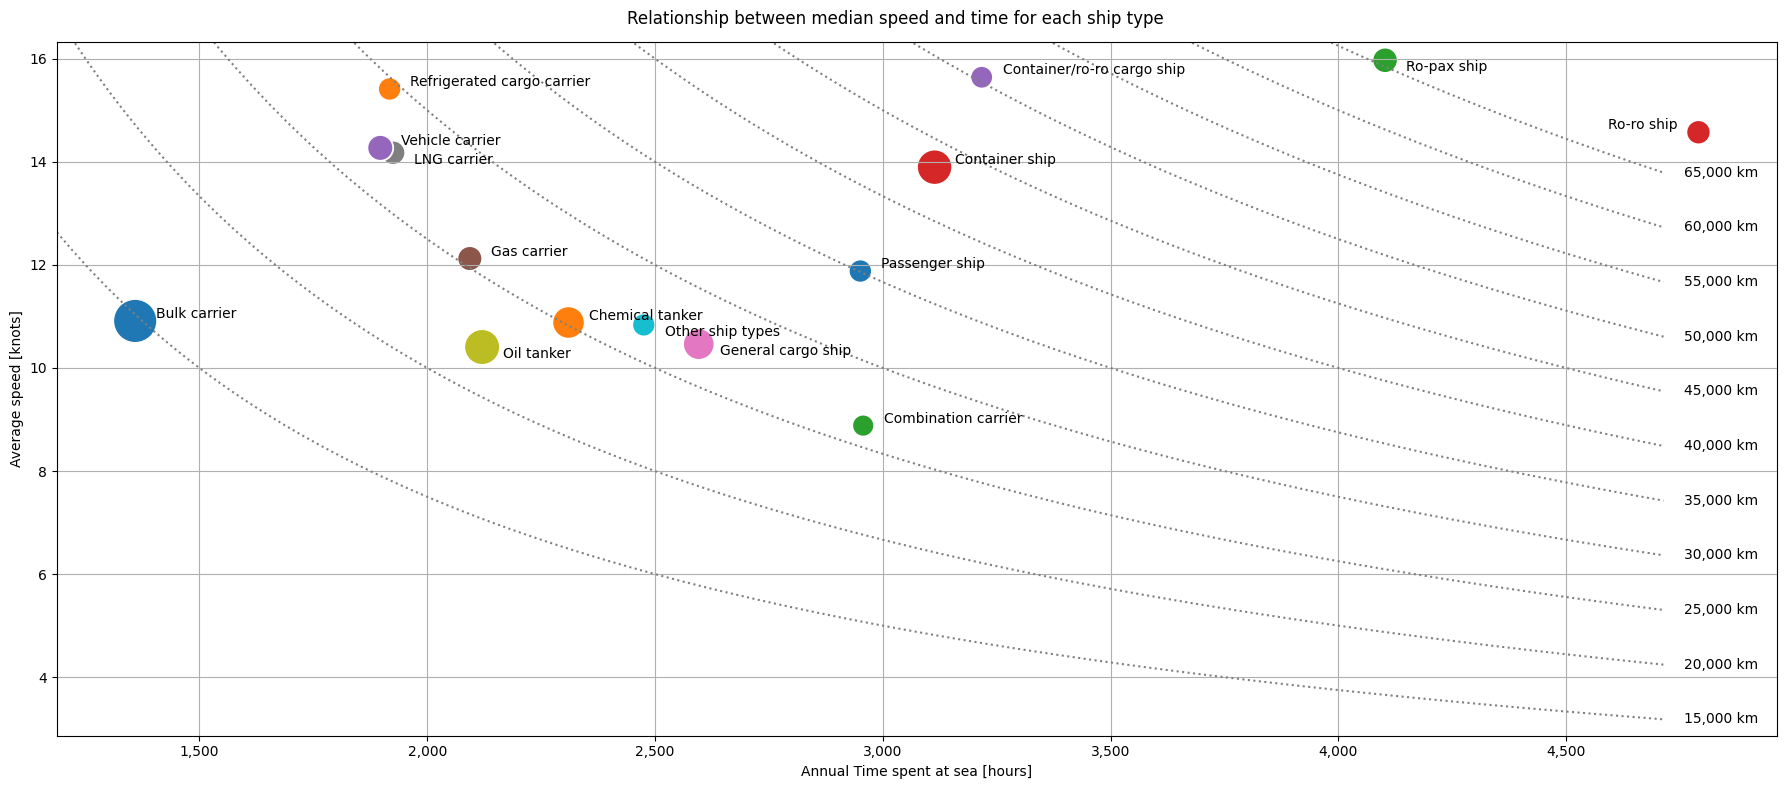

In [21]:
# display ship speed and time for each ship type

# initialise figure
fig, ax = plt.subplots(figsize=(18, 8))

# summarise values for each ship type
main_df_summ = (
    main_df[["Annual Time spent at sea [hours]", "Average speed [knots]", "Ship type"]]
    .groupby("Ship type")
    .median()
)
main_df_summ["count"] = main_df["Ship type"].value_counts()

# plot values
sns.scatterplot(
    data=main_df_summ,
    x="Annual Time spent at sea [hours]",
    y="Average speed [knots]",
    hue="Ship type",
    size="count",
    palette="tab10",
    sizes=(250, 1000),
    legend=False,
    ax=ax,
)

# annotate plot with ship type labels in place of legend
for name, series in main_df_summ.iterrows():
    x = series["Annual Time spent at sea [hours]"]
    y = series["Average speed [knots]"]
    ha = "right" if name in ["Ro-ro ship"] else "left"
    h_off = -15 if name in ["Ro-ro ship"] else 15
    v_off = (
        -5
        if name
        in [
            "General cargo ship",
            "LNG carrier",
            "Oil tanker",
            "Other ship types",
            "Ro-pax ship",
        ]
        else 5
    )
    ax.annotate(
        text=name,
        xy=(x, y),
        xytext=(h_off, v_off),
        textcoords="offset points",
        ha=ha,
        va="center",
    )

# get axes limits before contour plots
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

# add contour plots of constant distance covered
x_cont = np.linspace(xmin, 0.95 * xmax, 100)
for d_cont in np.arange(15_000, 70_000, 5_000):
    y_cont = d_cont / x_cont
    ax.plot(x_cont, y_cont, ":", c="gray")
    ax.annotate(
        f"{d_cont:,.0f} km",
        (x_cont[-1], y_cont[-1]),
        xytext=(15, 0),
        textcoords="offset points",
        va="center",
    )
    ymin = min(y_cont.min() * 0.9, ymin)  # lower y axis minimum if needed

# reestablish axis limits
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)

# decorate axis
ax.grid(visible=True)
ax.xaxis.set_major_formatter(
    ticker.StrMethodFormatter("{x:,.0f}")
)  # add thousand separators
ax.yaxis.set_major_formatter(
    ticker.StrMethodFormatter("{x:,.0f}")
)  # add thousand separators

# decorate figure
fig.suptitle("Relationship between median speed and time for each ship type")
fig.tight_layout()

It can be seen that the ro-ro ships (_Container/ro-ro cargo ship_, _Ro-pax ship_ and _Ro-ro ship_) stood out as travelling the farthest. They all exhibit some of the highest median speeds of all ship types (3 of the top 4) as well as spending the most time at sea (all of the top 3). This combination of high speeds and large amounts of time travelling combine to ensure these are the ship types that travel the furthest each year.

### Ship type grouping

Due to the large number of ship types in the dataset, some of the required plots are very densely packed with information which in turn reduces the readability for the end user. One way to reduce this would be to combine ships which have similar technical attributes and uses. Therefore, the similarity of the technical attributes of ship types shall be used to propose potential groupings.

In [22]:
# prepare data for clustering

# drop irrelevant columns
main_df_clus = main_df.drop(
    columns=["IMO Number", "Reporting Period", "Technical efficiency type"]
)

# calculate the median value of each feature for each ship type
main_df_clus = main_df_clus.groupby("Ship type").median()

# standardise values to ensure columns with large numerical values do not dominate clustering
main_df_clus_scaled = pd.DataFrame(
    StandardScaler().fit_transform(main_df_clus),
    index=main_df_clus.index,
    columns=main_df_clus.columns,
)

In [23]:
# fit hierarchical model
model = AgglomerativeClustering(
    distance_threshold=0, n_clusters=None, linkage="average"
)  # hyperparameters ensure all ship types are clustered
model.fit(main_df_clus_scaled)

AgglomerativeClustering(distance_threshold=0, linkage='average',
                        n_clusters=None)

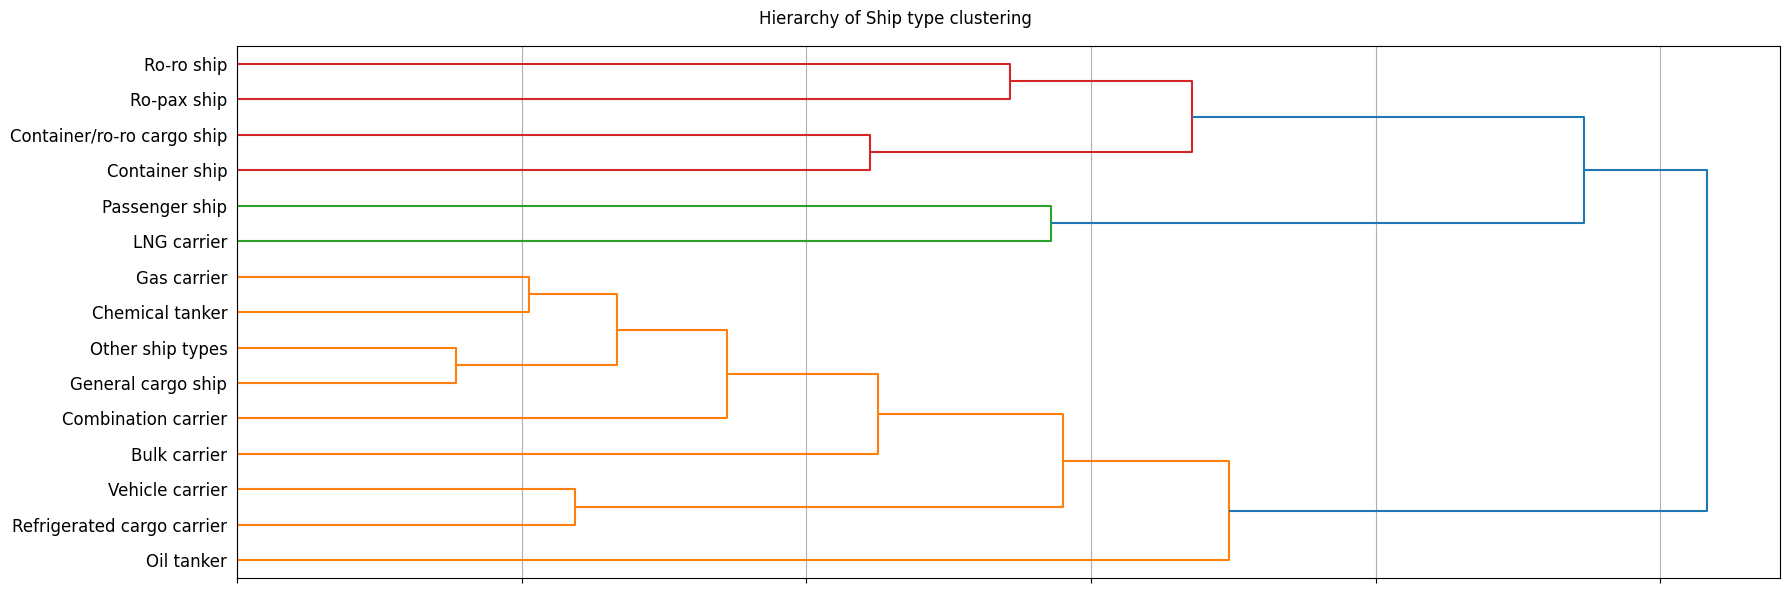

In [24]:
# plot hierarchy of ship type clustering

# initialise figure
fig, ax = plt.subplots(figsize=(18, 6))

# plot hierarchy
utils.dendrogram_from_model(
    model,
    truncate_mode=None,
    labels=main_df_clus_scaled.index,
    p=main_df_clus_scaled.shape[0],
    orientation="right",
    ax=ax,
)

# decorate axis
ax.grid(visible=True, axis="x")
ax.set_xticklabels([])

# decorate figure
fig.suptitle("Hierarchy of Ship type clustering")
fig.tight_layout()

The hierarchical clustering provided above shows which ship types have similar technical attributes and therefore which ship types could be combined to reduce the overall number of ship types displayed. Domain knowledge would suggest that these ship types would be good candidates for combination:
- _Ro-ro_ and _Ro-pax_
- _Container/ro-ro ship_ and _Container ship_
- _Other ships types_ and _General Cargo ship_

Some of the pairs of ship types exhibited technical similarity but domain knowledge would suggest their uses are sufficiently different that they shouldn't be combined:
- _Passenger ship_ and _LNG carrier_
- _Gas carrier_ and _Chemical Tanker_
- _Vehicle carrier_ and _Refrigerated cargo carrier_

### How accurate are the EIV calculations?

The technical efficiency values calcualted using the EIV method makes considerable assumptions about the vessel. It is possible that these assumptions are incorrect and that these values are potentially inaccurate.

#### Data preparation

In [25]:
# preprocess data

# drop columns that are irrelevant or derived from the target variable
df_reg = main_df.drop(
    columns=["IMO Number", "Deadweight [m tonnes]"]
)  # Technical efficiency type will be dropped later

# take logarithm of relevant columns
log_cols = [
    "Total fuel consumption [m tonnes]",
    "Total CO₂ emissions [m tonnes]",
    "Annual Time spent at sea [hours]",
    "Annual average Fuel consumption per distance [kg / n mile]",
    "Annual average CO₂ emissions per distance [kg CO₂ / n mile]",
    "Technical efficiency value [gCO₂/t·nm]",
    "Distance travelled [n mile]",
    "Average speed [knots]",
]
df_reg[log_cols] = utils.log2_fun(df_reg[log_cols])

# drop rows containing nulls
assert df_reg.isnull().any(axis=1).mean() < 0.1
df_reg.dropna(inplace=True)

# split out data based on efficiency calculation method
df_reg_EEDI = df_reg.loc[df_reg["Technical efficiency type"] == "EEDI"].drop(
    columns=["Technical efficiency type"]
)
df_reg_EIV = df_reg.loc[df_reg["Technical efficiency type"] == "EIV"].drop(
    columns=["Technical efficiency type"]
)

# split out test and train datasets
df_reg_EEDI_train, df_reg_EEDI_test = train_test_split(
    df_reg_EEDI, test_size=0.1, random_state=seed
)

# split out features and target variables
target = "Technical efficiency value [gCO₂/t·nm]"
df_reg_EEDI_train_X = df_reg_EEDI_train.drop(columns=target)
df_reg_EEDI_train_y = df_reg_EEDI_train[target]
df_reg_EEDI_test_X = df_reg_EEDI_test.drop(columns=target)
df_reg_EEDI_test_y = df_reg_EEDI_test[target]
df_reg_EIV_X = df_reg_EIV.drop(columns=target)
df_reg_EIV_y = df_reg_EIV[target]

In [26]:
# create vectorisation transformer

# define individual transformers for each column type
cat_trans = OneHotEncoder(handle_unknown="ignore", drop="if_binary")
cat_cols = ["Ship type"]
num_trans = StandardScaler()
num_cols = [
    "Reporting Period",
    "Total fuel consumption [m tonnes]",
    "Total CO₂ emissions [m tonnes]",
    "Annual Time spent at sea [hours]",
    "Annual average Fuel consumption per distance [kg / n mile]",
    "Annual average CO₂ emissions per distance [kg CO₂ / n mile]",
    "Distance travelled [n mile]",
    "Average speed [knots]",
]

# define column transformer
col_trans = ColumnTransformer(
    transformers=[
        ("cat", cat_trans, cat_cols),
        ("num", num_trans, num_cols),
    ],
    remainder="passthrough",
)

In [27]:
# vectorise data

# fit transformer and extract feature names
col_trans.fit(df_reg_EEDI_train_X)
feat_names, col_names = utils.get_feat_names(col_trans, df_reg_EEDI_train_X)

# transform train data
df_reg_EEDI_train_X_vect = pd.DataFrame(
    col_trans.transform(df_reg_EEDI_train_X),
    index=df_reg_EEDI_train_X.index,
    columns=feat_names,
)

# transform test data
df_reg_EEDI_test_X_vect = pd.DataFrame(
    col_trans.transform(df_reg_EEDI_test_X),
    index=df_reg_EEDI_test_X.index,
    columns=feat_names,
)

# transform EIV data
df_reg_EIV_X_vect = pd.DataFrame(
    col_trans.transform(df_reg_EIV_X),
    index=df_reg_EIV_X.index,
    columns=feat_names,
)

#### Model fitting

In [28]:
# tune hyperparameters - this combination of parameters approximately covers unregularised, lasso, ridge and elastic net forms of linear regression
params_search = {
    "alpha": 10.0 ** np.arange(-3, 1, 1),
    "l1_ratio": np.linspace(0.05, 0.95, 5),
}
est = ElasticNet(max_iter=10_000)
est_search = GridSearchCV(
    est, params_search, n_jobs=2, cv=3, verbose=1, return_train_score=True
)
est_search.fit(df_reg_EEDI_train_X_vect, df_reg_EEDI_train_y)
search_df = pd.DataFrame(est_search.cv_results_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,mean_fit_time,param_alpha,param_l1_ratio,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.012887,1.0,0.05,0.144039,0.003740,0.144557,0.002776
1,0.011326,0.1,0.95,0.285737,0.007235,0.287050,0.006628
2,0.013437,0.1,0.725,0.363408,0.007644,0.364538,0.005995
3,0.020797,0.1,0.5,0.429618,0.006470,0.430570,0.004879
4,0.021658,0.1,0.275,0.474138,0.006523,0.475434,0.003708


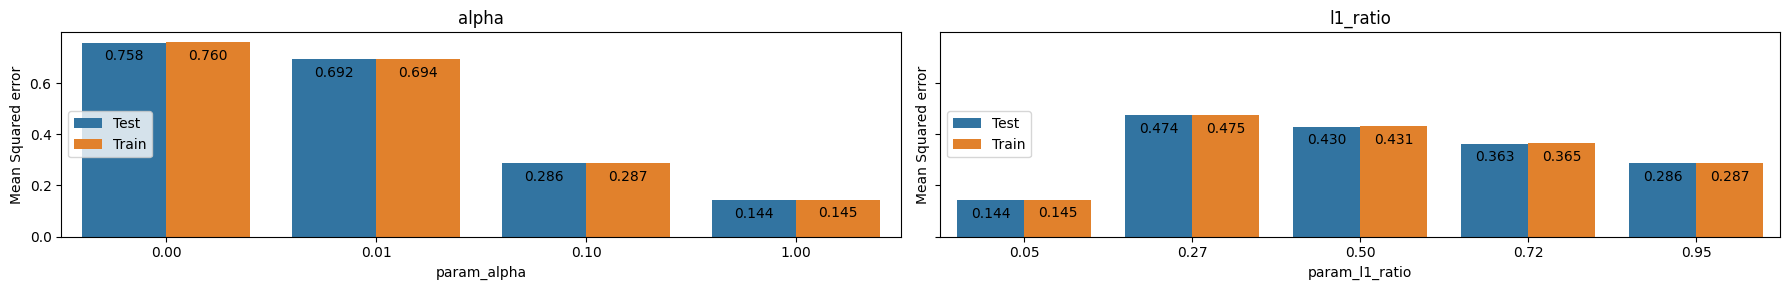

In [29]:
# display results

# filter out erroneously low scores and sort by performance
search_df = search_df.loc[search_df["mean_test_score"] > 0.01]
search_df.sort_values(by=["mean_test_score"], inplace=True, ignore_index=True)

# extract optimal parameters for final model
params = search_df.loc[0, "params"]

# display results as dataframe and pltos
search_df = utils.drop_columns(search_df)
utils.grouped_plot(search_df)
search_df.drop(columns="params").head()

As the model's best performance occurs with the lowest L1 ratio, the final model shall be a Ridge model (no L1 penalty) with alpha of 1. It is unclear as to why the increasing alpha values improve performance on the training set. Regularisation would be expected to reduce overfitting and could therefore improve test set performance if over fitting is present but this is not the case here.

In [30]:
# fit final model
est = Ridge(alpha=params["alpha"])
est.fit(df_reg_EEDI_train_X_vect, df_reg_EEDI_train_y)

Ridge()

In [31]:
# display the coefficient of the year feature
coef_df = pd.Series(est.coef_, index=feat_names).to_frame(name="value")
coef_df[["CI_low", "CI_upp"]] = utils.coef_ci(
    X=df_reg_EEDI_train_X_vect,
    y=df_reg_EEDI_train_y,
    model=est,
    alpha=0.05,
)
coef_df.loc["Reporting Period"].round(3)

value    -0.028
CI_low   -0.036
CI_upp   -0.020
Name: Reporting Period, dtype: float64

The coefficient for the year is (at a 95% significance) negative, suggesting that efficiency is improving each year. This is likely due to the replacement of old vessels with low efficiency by newer, more efficient, ships.

#### Model performance evaluation

In [32]:
# make predictions
df_reg_EEDI_train["Predicted technical efficiency value [gCO₂/t·nm]"] = est.predict(
    df_reg_EEDI_train_X_vect
)
df_reg_EEDI_test["Predicted technical efficiency value [gCO₂/t·nm]"] = est.predict(
    df_reg_EEDI_test_X_vect
)
df_reg_EIV["Predicted technical efficiency value [gCO₂/t·nm]"] = est.predict(
    df_reg_EIV_X_vect
)

In [33]:
# revert logarithm transform of relevant columns
updated_log_cols = log_cols + ["Predicted technical efficiency value [gCO₂/t·nm]"]
df_reg_EEDI_train[updated_log_cols] = np.exp2(df_reg_EEDI_train[updated_log_cols])
df_reg_EEDI_test[updated_log_cols] = np.exp2(df_reg_EEDI_test[updated_log_cols])
df_reg_EIV[updated_log_cols] = np.exp2(df_reg_EIV[updated_log_cols])

In [34]:
# calculate residuals
df_reg_EEDI_train["Residual [gCO₂/t·nm]"] = (
    df_reg_EEDI_train["Technical efficiency value [gCO₂/t·nm]"]
    - df_reg_EEDI_train["Predicted technical efficiency value [gCO₂/t·nm]"]
)
df_reg_EEDI_test["Residual [gCO₂/t·nm]"] = (
    df_reg_EEDI_test["Technical efficiency value [gCO₂/t·nm]"]
    - df_reg_EEDI_test["Predicted technical efficiency value [gCO₂/t·nm]"]
)
df_reg_EIV["EIV overestimate [gCO₂/t·nm]"] = (
    df_reg_EIV["Technical efficiency value [gCO₂/t·nm]"]
    - df_reg_EIV["Predicted technical efficiency value [gCO₂/t·nm]"]
)

In [35]:
# calculate MSE for both datasets
pd.Series(
    {
        "Train": (df_reg_EEDI_train["Residual [gCO₂/t·nm]"] ** 2).mean(),
        "Test": (df_reg_EEDI_test["Residual [gCO₂/t·nm]"] ** 2).mean(),
    }
).round(2)

Train    12.21
Test     11.71
dtype: float64

It can be seen that the performance on the test set is very similar to that of the training set which suggests the model is not overfitting. Furthermore, the test set outperforms that observed during the hyperparameter tuning which is likely because of the larger dataset.

#### Evaluate impact of time

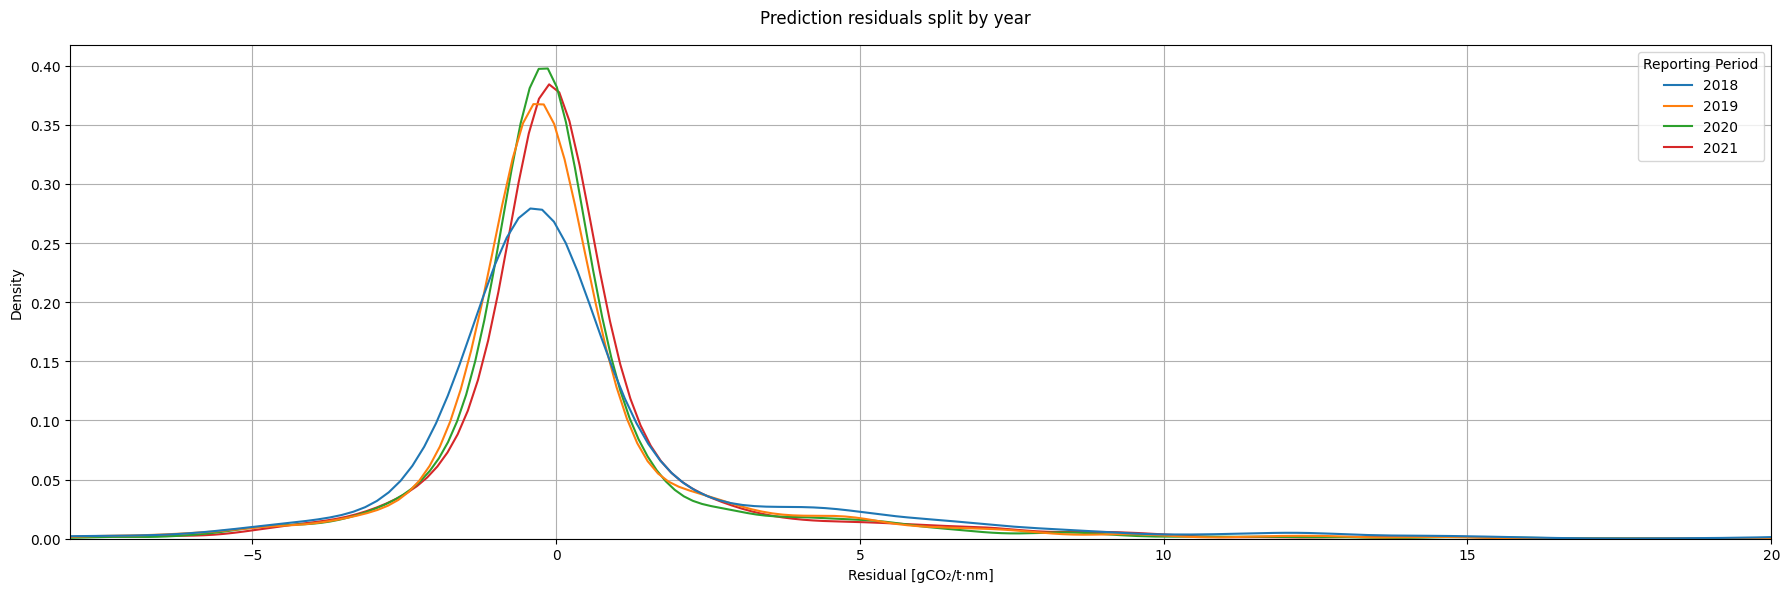

In [36]:
# plot residuals split by year

# initialise figure
fig, ax = plt.subplots(figsize=(18, 6))

# plot kde
sns.kdeplot(
    data=df_reg_EEDI_train.loc[
        df_reg_EEDI_train["Residual [gCO₂/t·nm]"].between(-10, 25)
    ],
    x="Residual [gCO₂/t·nm]",
    hue="Reporting Period",
    palette="tab10",
    common_norm=False,
    ax=ax,
)

# decorate axis
ax.grid(visible=True)
ax.set_xlim(-8, 20)

# decorate figure
fig.suptitle("Prediction residuals split by year")
fig.tight_layout()

It can be seen that in the older years, the mode of the residuals is biased towards the negative (below 0) with an increasingly positive skew. This may be because some anomolous old ship were abnormally inefficient and had not yet been replaced. The result of this is that the model will be less accurate on older data because of this.

#### Compare EEDI predictions to provided EIV values

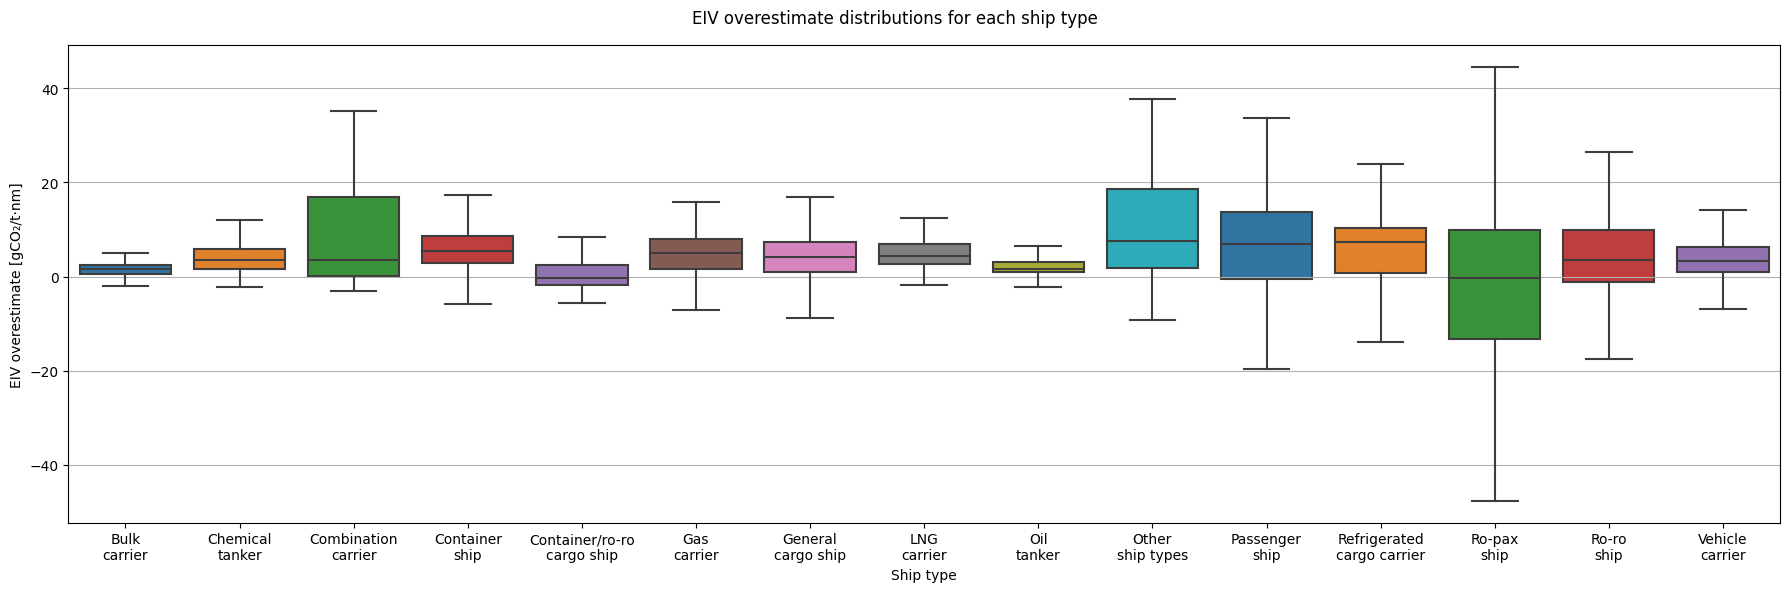

In [37]:
# plot EIV overestimate distributions split by ship type

# initialise figure
fig, ax = plt.subplots(figsize=(18, 6))

# plot box plots of ship size by ship type
sns.boxplot(
    data=df_reg_EIV,
    x="Ship type",
    y="EIV overestimate [gCO₂/t·nm]",
    palette="tab10",
    ax=ax,
    showfliers=False,
)

# decorate axis
ax.set_xticklabels(
    [x.get_text().replace(" ", "\n", 1) for x in ax.get_xticklabels()]
)  # make labels multiline
ax.grid(visible=True, axis="y")

# decorate figure
fig.suptitle("EIV overestimate distributions for each ship type")
fig.tight_layout()

It can be seen that across almost all the ship types, the EIV tends to overestimate the technical efficiency values which may be incorrectly suggesting that these vessels are less efficient than they are. Depending on the impact that the technical efficiency values have, it may be worthwhile allocating additional resources to ensure that a vessel's technical efficiency values are calculated using EEDI, not EIV. For example, if adding 10,000 USD of data gathering tools and sensors to a ship would allow EEDI to be used instead of EIV, and that efficiency value would reduce and save more than 10,000 USD over its lifetime then this would be commercially beneficial.

This analysis is inline with the overestimate correlation observed in section 2.2 of Transport and Environment office's [_Analysis of EIVs of Ships That Have Entered The Fleet Since 2009_](https://www.transportenvironment.org/wp-content/uploads/2021/07/2015%2005%20CE_Delft_7E50_Estimated_Index_Values_of_New_Ships_DEF.pdf) report which was published in 2015.